## Embedding Reveiws
- use TCU, otherwise, running Llama and Falcon will take up all RAM if you use CPU.

In [ ]:
!pip install transformers

In [ ]:
import transformers
import torch

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
pip install --upgrade huggingface_hub

In [ ]:
from huggingface_hub import login

In [ ]:
login()

In [ ]:
!pip install gensim nltk

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import torch
from gensim.models import Word2Vec
import gensim

# Tutorial from NLTK: https://www.nltk.org/data.html
# train the word2vec model that learns the word meaning in the bubble tea reviews

In [ ]:
# nltk.download() # this one runs endless
nltk.download('punkt')
nltk.download('punkt_tab')
# punkt explains: https://www.askpython.com/python-modules/nltk-punkt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Preprocess Data

In [ ]:
df = pd.read_csv("Tiger Suger Reviews-Indianapolis.csv")

df['Rating'] = df['Rating'].str.extract(r"(\d+)")
for i in range(len(df)):
    if df['Reviews'][i] == 'No review text available':
        df = df.drop(i)

reviews = df["Reviews"]
df.info()
np.array(ratings)


<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   60 non-null     object
 1   Reviews  60 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


array(['5', '5', '5', '3', '5', '1', '5', '5', '5', '5', '5', '5', '5',
       '5', '5', '5', '5', '5', '5', '5', '4', '5', '5', '5', '5', '5',
       '1', '5', '5', '5', '5', '3', '5', '1', '2', '5', '1', '5', '5',
       '1', '5', '5', '5', '1', '5', '5', '5', '5', '5', '5', '5', '5',
       '3', '5', '5', '5', '5', '5', '5', '5'], dtype=object)

## Word2Vec
- tutorial: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha()] # if word is alphabet letters

tokenized_reviews = []
# tokenize each review
for review in reviews:
    tokenized_reviews.append(preprocess(review))

# tokenized_reviews
# [['babo', 'tea'],['I','love', 'this']... ]

In [ ]:
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# This func transfers review tokens into vectors
def get_review_vector(tokens, model):

    # only keep the word in W2V model's vocabulary
    recognized_word_in_review= []
    word_vector = []

    for w in tokens:
        if w in model.wv.key_to_index: # {'the': 0, 'and': 1, 'i': 2,...}
            recognized_word_in_review.append(w)

    # if a review contains no model vocabuary, set its vector 0
    if len(recognized_word_in_review) == 0:
        return np.zeros(model.vector_size)

    # if has value, get the word vector and calculate the avg
    for w in recognized_word_in_review:
        word_vector.append(model.wv[w])

    review_vector = np.mean(word_vector, axis = 0)
    return review_vector

In [ ]:
review_vectors = []
for tokens in tokenized_reviews:
    review_vector = get_review_vector(tokens, w2v_model)
    review_vectors.append(review_vector)

In [ ]:
review_vectors = np.array(review_vectors) #convert it into a np array
print(review_vectors.shape)
# 607 reviews, each review is represented as 100-D vector

(607, 100)


Normalize rating & Reshape dimentions: convert 1-5 scale into 0~1

In [ ]:
ratings = df["Rating"]
normalized_ratings = np.array(ratings, dtype=float) / 5

# reshape normalized ratings into (607, 1)
reshaped_ratings = normalized_ratings.reshape(-1,1)
reshaped_ratings.shape

(60, 1)

Combine normalized ratings with review vectors

In [ ]:
final_review_vectors = np.hstack((review_vectors, reshaped_ratings))
final_review_vectors.shape

(607, 101)

## Llama 2-7b-chat-hf
- meta download: https://www.llama.com/llama-downloads/
- Huggingface: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- [Github tutorial](https://github.com/meta-llama/llama-models?fbclid=IwZXh0bgNhZW0CMTAAAR5flYgamnz7bViaAtMQsPvPWGc7jCd69MsAmom7zGFl6Mb9ckvqDYBeACJirg_aem_vjalf1yaPdUasJh9lNKd_g)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model.config.output_hidden_states = True

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Falcon

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

falcon_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model.config.output_hidden_states = True

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generate vectors by using Transformers

In [ ]:
def get_review_vector(review, tokenizer, model):

    input = tokenizer(review, return_tensors='pt', truncation=True)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().numpy()  #average all tokens

    return vector

In [ ]:
all_llama_vectors = []

for review in reviews:
    vector = get_review_vector(review, llama_tokenizer, llama_model)
    all_llama_vectors.append(vector)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
all_falcon_vectors = []
# only use Indianapolis data - 81 entries

for review in reviews:
    vector = get_review_vector(review, falcon_tokenizer, falcon_model)
    all_falcon_vectors.append(vector)


In [ ]:
llama_rating_combined_vectors = np.hstack((all_llama_vectors, reshaped_ratings))
llama_rating_combined_vectors.shape

(60, 4097)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(llama_rating_combined_vectors)
labels = kmeans.labels_

In [ ]:
df["Cluster"] = labels
df.head()

,Rating,Reviews,Cluster
0,5,The aesthetic is very cozy and inviting!! The ...,4
1,5,Tiger sugar is the epitome of a welcoming envi...,4
2,5,"If you are in or near Greenwood, IN looking fo...",4
3,3,A friend of mine had a negative experience her...,4
4,5,I never give reviews but i wanted to let yall ...,4


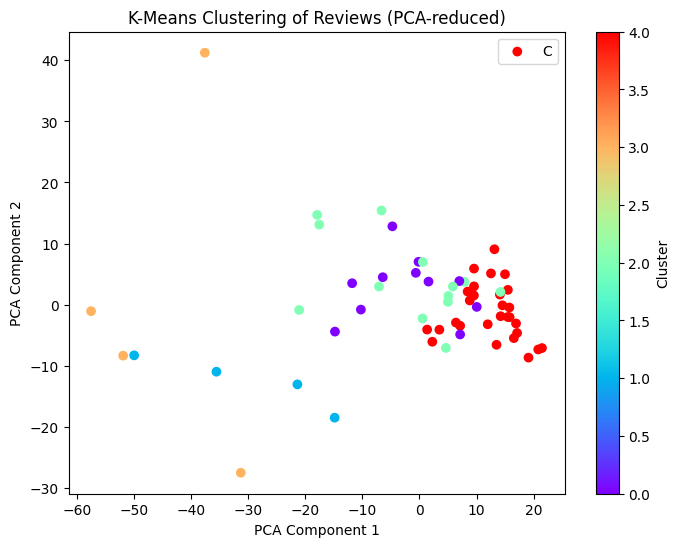

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
reduced = pca.fit_transform(llama_rating_combined_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
plt.title("K-Means Clustering of Reviews (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.legend('Cluster')
plt.show()

In [ ]:
df.to_csv('llama_60_cluster.csv', index=False)